In [ ]:
!pip install scikit-learn matplotlib seaborn

In [ ]:
!pip install graphviz pydotplus

              precision    recall  f1-score   support

           0       0.98      0.30      0.46       854
           1       0.92      1.00      0.96      7146

    accuracy                           0.92      8000
   macro avg       0.95      0.65      0.71      8000
weighted avg       0.93      0.92      0.91      8000



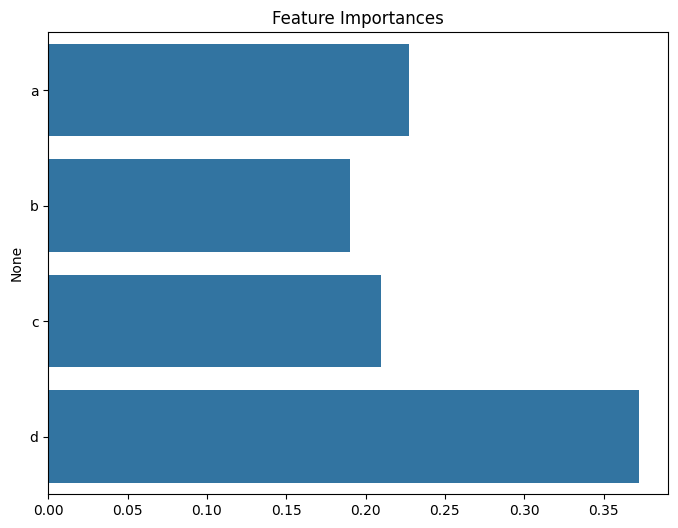

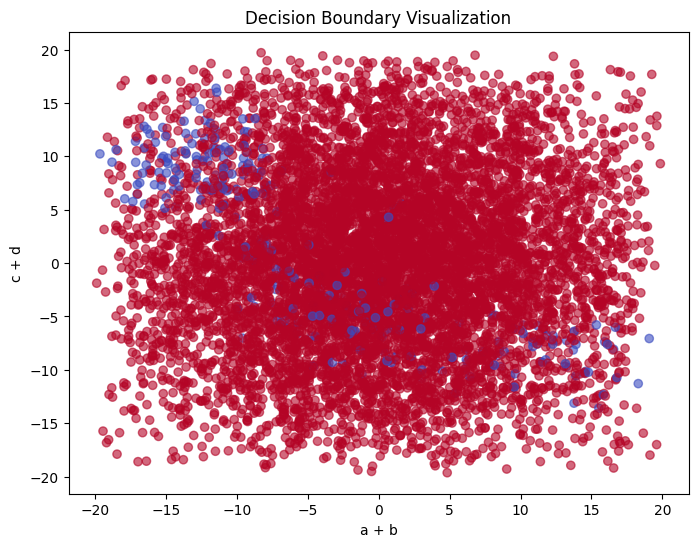

In [ ]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate Data
np.random.seed(42)

N = 40000
a = np.random.uniform(-10, 10, N)
b = np.random.uniform(-10, 10, N)
c = np.random.uniform(-10, 10, N)
d = np.random.uniform(-10, 10, N)

data = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d})

# Step 2: Determine if polynomial has all real roots
def has_complex_roots(a, b, c, d):
    coeffs = [1, a, b, c, d]
    roots = np.roots(coeffs)
    return np.any(np.iscomplex(roots))  # True if complex roots exist

data['complex_roots'] = [has_complex_roots(ai, bi, ci, di) for ai, bi, ci, di in zip(a, b, c, d)]

# Step 3: Prepare data for ML
X = data[['a', 'b', 'c', 'd']]
y = data['complex_roots'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=6)
clf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 6: Feature Importance Visualization
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances")
plt.show()

# Step 7: Bonus - Visualize decision boundary for a+b and c+d combination (optional insight)
plt.figure(figsize=(8,6))
plt.scatter(X_test['a'] + X_test['b'], X_test['c'] + X_test['d'], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.xlabel("a + b")
plt.ylabel("c + d")
plt.title("Decision Boundary Visualization")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Generate data again (same as before)
np.random.seed(42)

N = 40000
a = np.random.uniform(-10, 10, N)
b = np.random.uniform(-10, 10, N)
c = np.random.uniform(-10, 10, N)
d = np.random.uniform(-10, 10, N)

data = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d})

# Determine real/complex roots
def has_complex_roots(a, b, c, d):
    coeffs = [1, a, b, c, d]
    roots = np.roots(coeffs)
    return np.any(np.iscomplex(roots))

data['complex_roots'] = [has_complex_roots(ai, bi, ci, di) for ai, bi, ci, di in zip(a, b, c, d)]

# Solving for a1, a2, a3, a4
def solve_a1_a2_a3_a4(a, b, c, d):
    solutions = []

    # Solve quadratic for a4 using d = a2 * a4
    # Try different a4 candidates (avoid a4 = 0)
    for sign in [1, -1]:
        if d == 0:
            a4 = 0.00001  # avoid division by zero
        else:
            a4 = sign * np.sqrt(abs(d))  # guess a4

        a2 = d / a4 if a4 != 0 else 0

        # Solve quadratic for a1
        # b = a4 + a1*(a - a1) + a2
        # => a1^2 - a*a1 + (a4 + a2 - b) = 0
        coef = [1, -a, (a4 + a2 - b)]
        roots_a1 = np.roots(coef)

        for a1_candidate in roots_a1:
            if np.iscomplex(a1_candidate):
                continue  # skip complex solutions

            a1 = np.real(a1_candidate)
            a3 = a - a1

            solutions.append((a1, a2, a3, a4))

    return solutions

# Apply and select first solution for rule calculation
a1_list = []
a2_list = []
a3_list = []
a4_list = []

for row in data.itertuples(index=False):
    solutions = solve_a1_a2_a3_a4(row.a, row.b, row.c, row.d)

    if len(solutions) == 0:
        a1, a2, a3, a4 = 0, 0, 0, 0  # fallback if no solution
    else:
        a1, a2, a3, a4 = solutions[0]  # take first valid solution

    a1_list.append(a1)
    a2_list.append(a2)
    a3_list.append(a3)
    a4_list.append(a4)

data['a1'] = a1_list
data['a2'] = a2_list
data['a3'] = a3_list
data['a4'] = a4_list

# Calculate Rule 1 and Rule 2
data['rule1'] = (np.array(data['a1'])**2 - 4 * np.array(data['a2'])) < 0
data['rule2'] = (np.array(data['a3'])**2 - 4 * np.array(data['a4'])) < 0

# Final rule prediction
data['rule_predicted_complex'] = data['rule1'] | data['rule2']

# Compare rule vs actual
from sklearn.metrics import confusion_matrix

print("Confusion Matrix (Rule vs True Label):")
print(confusion_matrix(data['complex_roots'], data['rule_predicted_complex']))

print("\nClassification Report:")
print(classification_report(data['complex_roots'], data['rule_predicted_complex']))



Confusion Matrix (Rule vs True Label):
[[ 1955  2234]
 [10127 25684]]

Classification Report:
              precision    recall  f1-score   support

       False       0.16      0.47      0.24      4189
        True       0.92      0.72      0.81     35811

    accuracy                           0.69     40000
   macro avg       0.54      0.59      0.52     40000
weighted avg       0.84      0.69      0.75     40000



|--- b <= -4.80
|   |--- d <= -1.02
|   |   |--- d <= -1.57
|   |   |   |--- d <= -2.32
|   |   |   |   |--- c <= 8.91
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- c >  8.91
|   |   |   |   |   |--- class: 1
|   |   |   |--- d >  -2.32
|   |   |   |   |--- c <= 9.09
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- c >  9.09
|   |   |   |   |   |--- class: 0
|   |   |--- d >  -1.57
|   |   |   |--- c <= -6.89
|   |   |   |   |--- a <= -0.14
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- a >  -0.14
|   |   |   |   |   |--- class: 0
|   |   |   |--- c >  -6.89
|   |   |   |   |--- c <= 7.39
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- c >  7.39
|   |   |   |   |   |--- class: 0
|   |--- d >  -1.02
|   |   |--- d <= 4.89
|   |   |   |--- d <= -0.25
|   |   |   |   |--- c <= 5.70
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- c >  5.70
|   |   |   |   |   |--- class: 0
|   |   |   |--- d >  -0.25
|   |   |   |   |--- d <= 2.32
|   |   |   |   |   |-

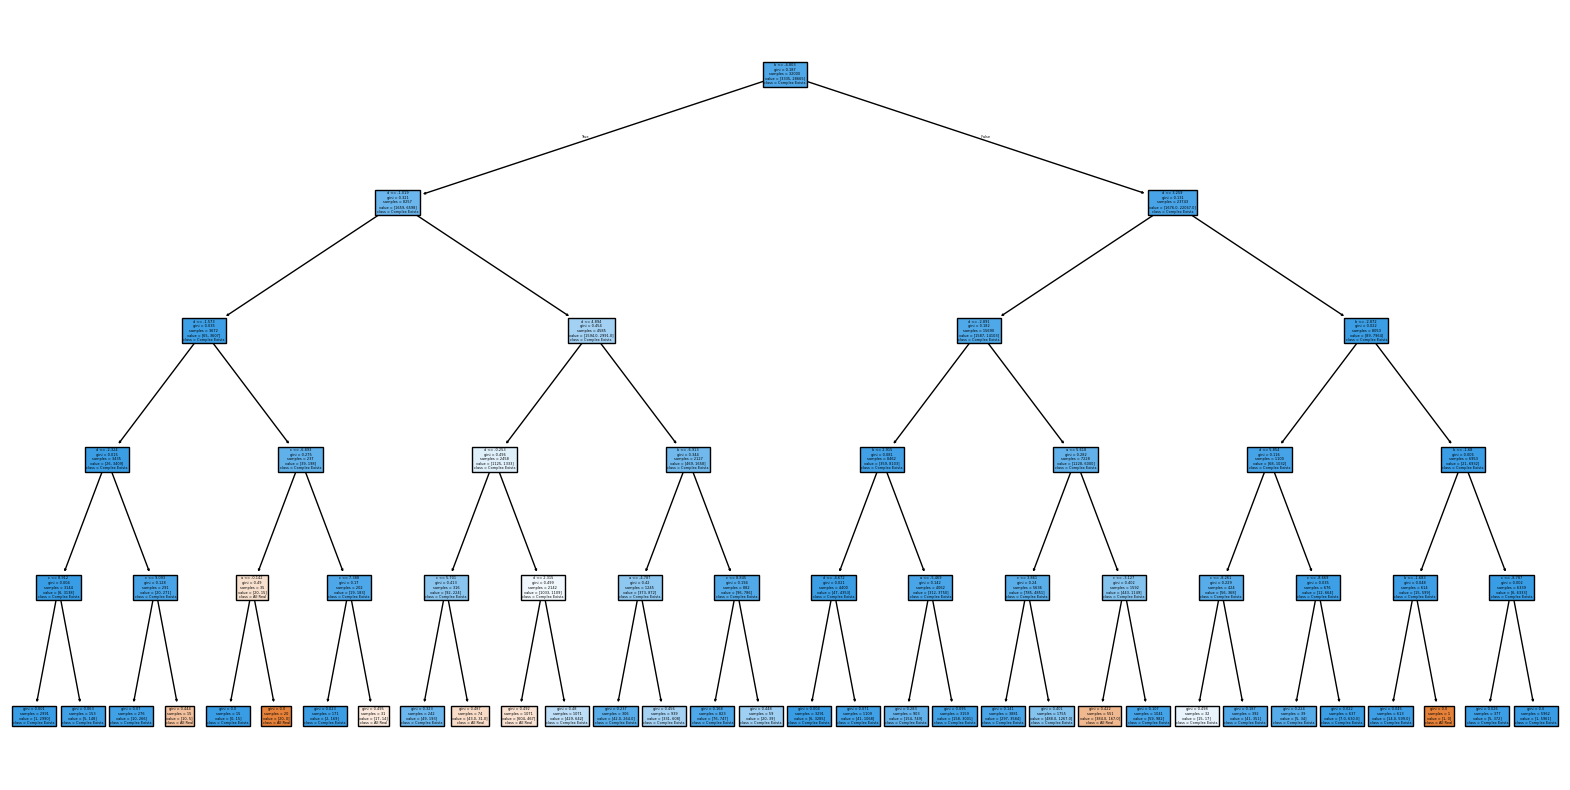

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       854
           1       1.00      1.00      1.00      7146

    accuracy                           0.99      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.99      0.99      0.99      8000

Decision Tree Accuracy: 0.901125
Neural Network Accuracy: 0.9915


In [ ]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Generate data again (same as before)
np.random.seed(42)

N = 40000
a = np.random.uniform(-10, 10, N)
b = np.random.uniform(-10, 10, N)
c = np.random.uniform(-10, 10, N)
d = np.random.uniform(-10, 10, N)

data = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d})

# Determine real/complex roots
def has_complex_roots(a, b, c, d):
    coeffs = [1, a, b, c, d]
    roots = np.roots(coeffs)
    return np.any(np.iscomplex(roots))

data['complex_roots'] = [has_complex_roots(ai, bi, ci, di) for ai, bi, ci, di in zip(a, b, c, d)]

# Split data
X = data[['a', 'b', 'c', 'd']]
y = data['complex_roots'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----- Decision Tree -----
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

tree_rules = export_text(dt, feature_names=['a', 'b', 'c', 'd'])
print(tree_rules)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Visualize tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=['a', 'b', 'c', 'd'], class_names=['All Real', 'Complex Exists'], filled=True)
plt.show()

# ----- Neural Network -----
nn = MLPClassifier(hidden_layer_sizes=(16, 16), activation='relu', max_iter=1000)
nn.fit(X_train, y_train)

y_pred_nn = nn.predict(X_test)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Accuracy comparison
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))


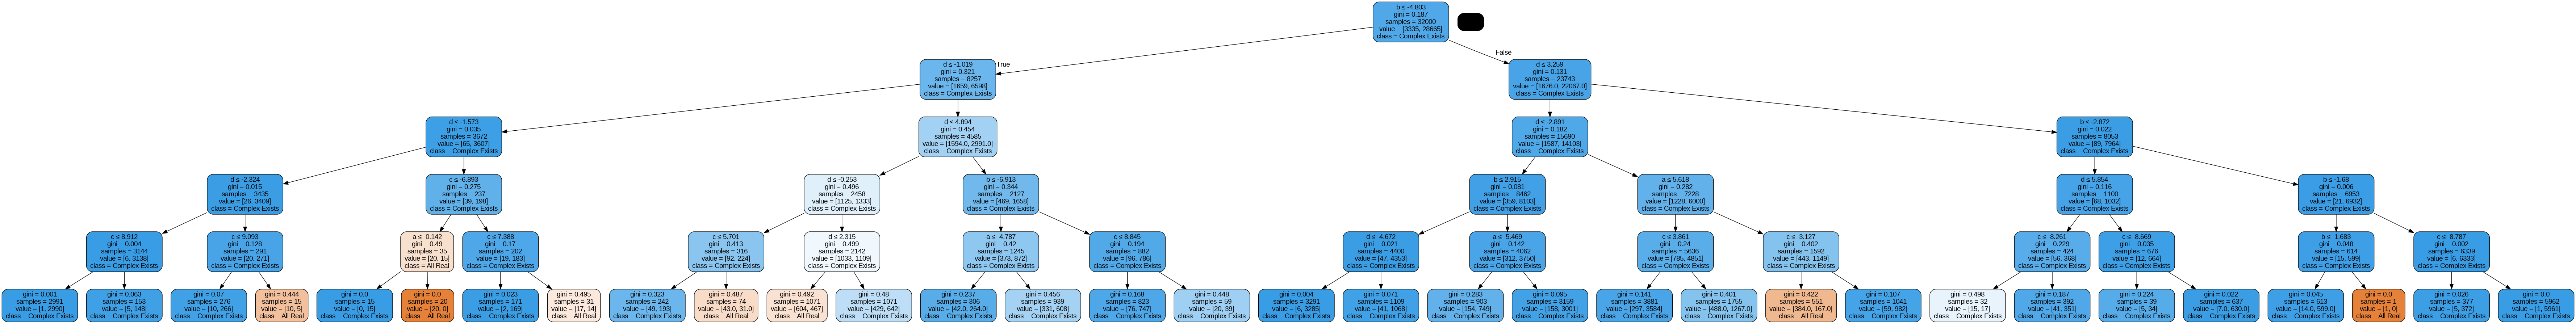

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz

# Export as dot file
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=['a', 'b', 'c', 'd'],
    class_names=['All Real', 'Complex Exists'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Create graph from dot data
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the graph in notebook
Image(graph.create_png())


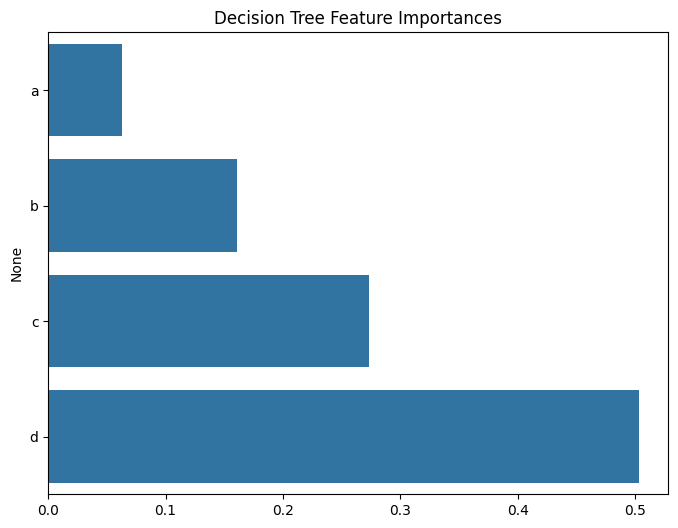

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(dt.feature_importances_, index=['a', 'b', 'c', 'd'])

plt.figure(figsize=(8,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Decision Tree Feature Importances")
plt.show()


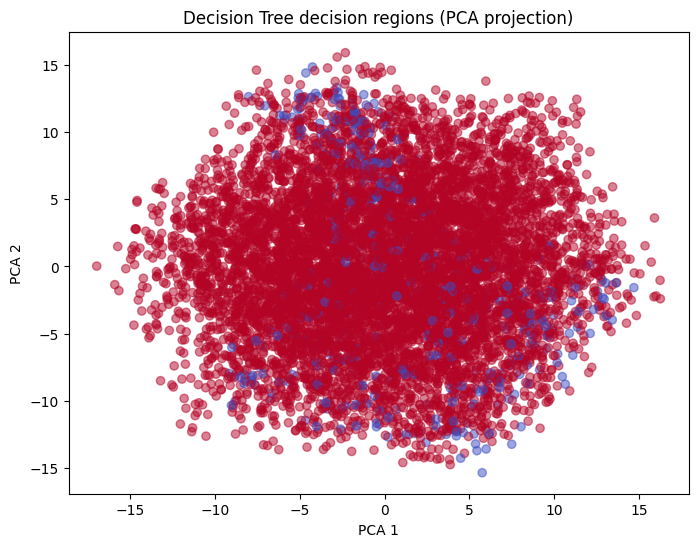

In [ ]:
from sklearn.decomposition import PCA

# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_dt, cmap='coolwarm', alpha=0.5)
plt.title("Decision Tree decision regions (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


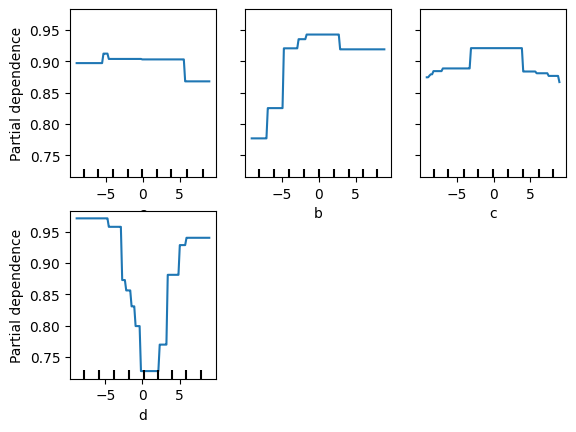

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

features = ['a', 'b', 'c', 'd']
PartialDependenceDisplay.from_estimator(dt, X_test, features)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
N = 40000
a = np.random.uniform(-10, 10, N)
b = np.random.uniform(-10, 10, N)
discriminant = a**2 - 4*b
r = (discriminant < 0).astype(int)

# Check ratio of complex roots
print("Ratio of complex roots:", np.mean(r))


Ratio of complex roots: 0.210675


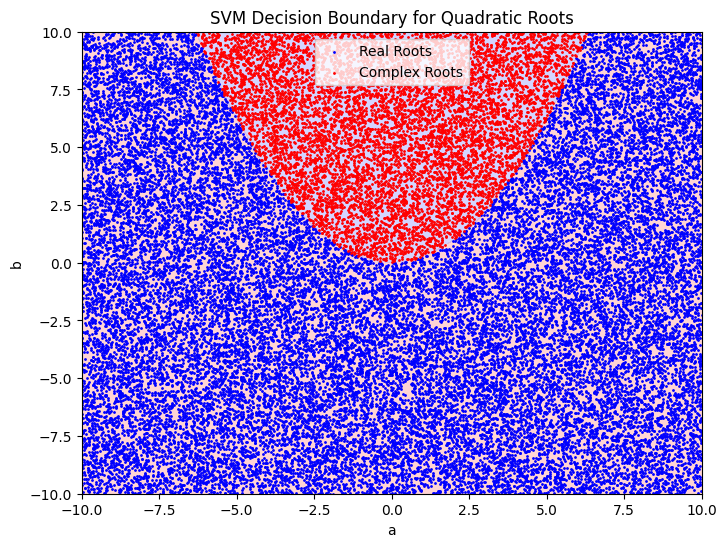

In [ ]:
from sklearn.svm import SVC

X = np.column_stack((a, b))
y = r

# Train SVM with RBF kernel (or linear for this simple case)
clf = SVC(kernel='rbf', gamma='auto')
clf.fit(X, y)

# Create a mesh to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAAAFF'], alpha=0.5)
plt.scatter(a[r==0], b[r==0], color='blue', s=1, label='Real Roots')
plt.scatter(a[r==1], b[r==1], color='red', s=1, label='Complex Roots')
plt.xlabel('a')
plt.ylabel('b')
plt.title('SVM Decision Boundary for Quadratic Roots')
plt.legend()
plt.show()


In [ ]:
from sympy import symbols, discriminant, Poly

def quartic_discriminant(a, b, c, d):
    x = symbols('x')
    poly = Poly(x**4 + a*x**3 + b*x**2 + c*x + d, x)
    return discriminant(poly)


In [ ]:
import numpy as np
from sympy import N

N_samples = 40000
a = np.random.uniform(-10, 10, N_samples)
b = np.random.uniform(-10, 10, N_samples)
c = np.random.uniform(-10, 10, N_samples)
d = np.random.uniform(-10, 10, N_samples)

# Compute discriminant and assign labels
labels = []
for i in range(N_samples):
    delta = quartic_discriminant(a[i], b[i], c[i], d[i])
    delta = float(N(delta))  # Convert sympy result to float
    # Label: 1 if complex roots exist, 0 if all roots real (per your homework's rule)
    labels.append(1 if delta < 0 else 0)

labels = np.array(labels)


In [ ]:
from sklearn.svm import SVC

X = np.column_stack((a, b, c, d))
y = labels

clf = SVC(kernel='rbf', gamma='auto')
clf.fit(X, y)


SVC(gamma='auto')

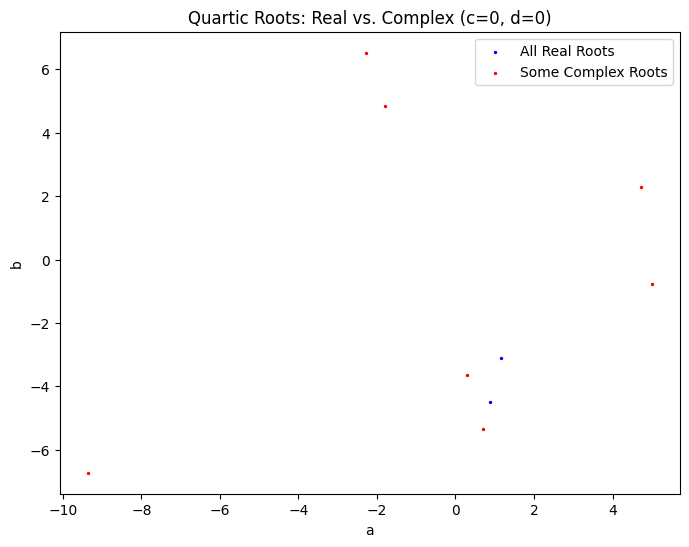

In [ ]:
import matplotlib.pyplot as plt

# Fix c=0, d=0 for visualization
mask = (np.abs(c) < 0.1) & (np.abs(d) < 0.1)
a_plot = a[mask]
b_plot = b[mask]
y_plot = y[mask]

plt.figure(figsize=(8,6))
plt.scatter(a_plot[y_plot==0], b_plot[y_plot==0], color='blue', s=2, label='All Real Roots')
plt.scatter(a_plot[y_plot==1], b_plot[y_plot==1], color='red', s=2, label='Some Complex Roots')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Quartic Roots: Real vs. Complex (c=0, d=0)')
plt.legend()
plt.show()


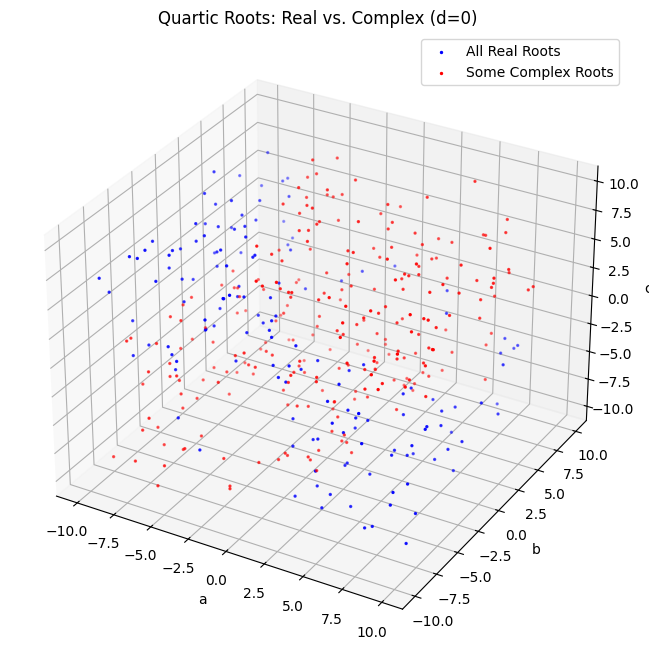

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Fix d=0 for 3D plot
mask = np.abs(d) < 0.1
a_3d = a[mask]
b_3d = b[mask]
c_3d = c[mask]
y_3d = y[mask]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a_3d[y_3d==0], b_3d[y_3d==0], c_3d[y_3d==0], color='blue', s=2, label='All Real Roots')
ax.scatter(a_3d[y_3d==1], b_3d[y_3d==1], c_3d[y_3d==1], color='red', s=2, label='Some Complex Roots')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c')
ax.set_title('Quartic Roots: Real vs. Complex (d=0)')
ax.legend()
plt.show()
